In [36]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [49]:
q117 = pd.DataFrame.from_csv('data/LoanStats_2017Q1.csv', index_col=None, header=1)
q117.head()

C:\Users\richa\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (0,112) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_il_6m,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
0,NaN,NaN,3600.0,3600.0,3600.0,36 months,7.49%,111.97,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,15000.0,15000.0,15000.0,60 months,14.99%,356.78,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,8400.0,8400.0,8400.0,36 months,11.39%,276.56,B,B3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000.0,4000.0,4000.0,36 months,10.49%,130.00,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,6000.0,6000.0,6000.0,36 months,7.24%,185.93,A,A3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


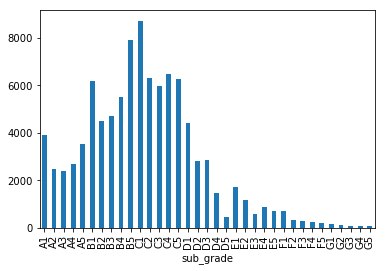

In [50]:
# plot sub_grade distribution. Note: would be nice to be able to show this by % breakout
q117.groupby('sub_grade').size().plot(kind='bar')

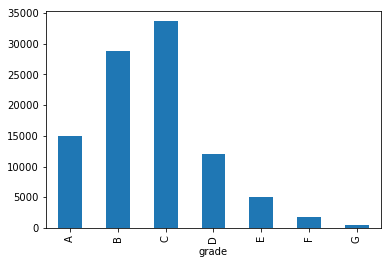

In [51]:
# plot grade distribution. Note: same % comment as above
q117.groupby('grade').size().plot(kind='bar')

In [52]:
# convert int_rate column from strings to floats
q117.int_rate = q117.int_rate.str.strip('%')
q117.int_rate = q117.int_rate.astype(float)

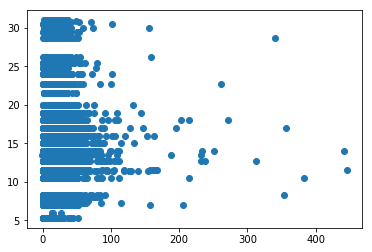

In [75]:
# scatter plot dti (debt to income ratio) vs interest rate. Exclude dti >= 500. Inconclusive chart
q117dti = q117[q117.dti<500]
fig, axes = plt.subplots()
axes.scatter(q117dti.dti, q117dti.int_rate)

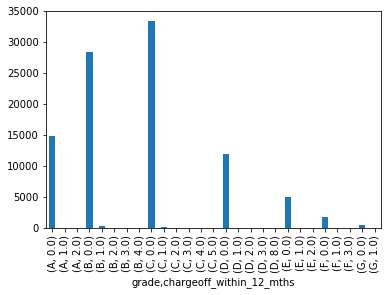

In [83]:
# attempt to plot # of chargeoffs within 12 months by grade. Chart would be better if this could be shown as a % breakout
q117.groupby(['grade', 'chargeoff_within_12_mths']).size().plot(kind='bar')

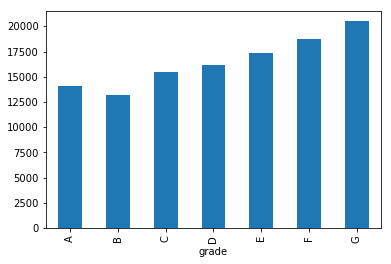

In [87]:
# plot average loan size by grade. Interestingly, loan size increases as credit quality decreases
# again, would be nice to have this by % breakout. I also want to add some correlation stats
q117.groupby('grade').mean().loan_amnt.plot(kind='bar')

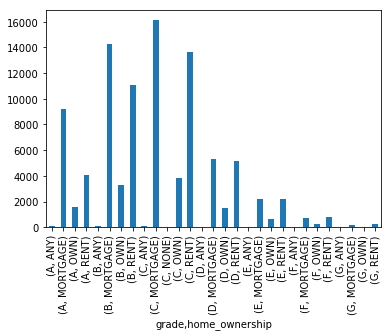

In [90]:
# plot home ownership type count by grade. Again, would be nice to have this by % breakout
q117.groupby(['grade', 'home_ownership']).size().plot(kind='bar')